# Import and setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import few

from few.trajectory.inspiral import EMRIInspiral
from few.trajectory.ode import KerrEccEqFlux
# from few.amplitude.romannet import RomanAmplitude
from few.amplitude.ampinterp2d import AmpInterpKerrEccEq
from few.summation.interpolatedmodesum import InterpolatedModeSum 


from few.utils.ylm import GetYlms

from few import get_file_manager

from few.waveform import FastKerrEccentricEquatorialFlux

from few.utils.geodesic import get_fundamental_frequencies

import os
import sys
# Change to the desired directory
os.chdir('/nfs/home/svu/e1498138/localgit/FEWNEW/work/')

# Add it to Python path
sys.path.insert(0, '/nfs/home/svu/e1498138/localgit/FEWNEW/work/')

import GWfuncs
# import gc
# import pickle
import cupy as cp

# tune few configuration
cfg_set = few.get_config_setter(reset=True)
cfg_set.set_log_level("info");

# Generating waveform via FEW func

In [2]:
# Parameters
m1 = 1e6 #M
m2 = 1e1 #mu
a = 0.5
p0 = 9.5
e0 = 0.2
theta = np.pi / 3.0 
phi = np.pi / 4.0  
dt = 10.0
T = 1
xI0 = 1.0 
dist = 1 #Gpc
#in the paper xI0 = 0.866, but that would be non-equatorial case

use_gpu = True 
func = "KerrEccentricEquatorial"


In [3]:
# keyword arguments for inspiral generator 
inspiral_kwargs={
        "func": 'KerrEccEqFlux',
        "DENSE_STEPPING": 0, #change to 1/True for uniform sampling
        "include_minus_m": False, 
        "use_gpu" : use_gpu,
        "force_backend": "cuda12x"  # Force GPU
}

# keyword arguments for inspiral generator 
amplitude_kwargs = {
    "force_backend": "cuda12x",  # Force GPU
    # "use_gpu" : use_gpu
}

# keyword arguments for Ylm generator (GetYlms)
Ylm_kwargs = {
    "force_backend": "cuda12x",  # Force GPU
    # "assume_positive_m": True  # if we assume positive m, it will generate negative m for all m>0
}

# keyword arguments for summation generator (InterpolatedModeSum)
sum_kwargs = {
    "force_backend": "cuda12x",  # Force GPU
    "pad_output": False,
    # "use_gpu" : use_gpu
}

# Kerr eccentric flux
waveform_gen = FastKerrEccentricEquatorialFlux(
    inspiral_kwargs=inspiral_kwargs,
    amplitude_kwargs=amplitude_kwargs,
    Ylm_kwargs=Ylm_kwargs,
    sum_kwargs=sum_kwargs,
    use_gpu=use_gpu,
)


In [4]:
%%time
# Generate template waveform
h_temp = waveform_gen(m1, m2, a, p0, e0, xI0, theta, phi, dist=dist, dt=dt, T=1)
cp.cuda.Stream.null.synchronize()

CPU times: user 12.4 s, sys: 526 ms, total: 12.9 s
Wall time: 13.2 s


In [5]:
N = int(len(h_temp)) 
print(N)
gwf = GWfuncs.GravWaveAnalysis(N=N,dt=dt)

3155815


In [6]:
factor = gwf.dist_factor(dist, m2)

In [7]:
%%time
#Generating data (true)
# varying the params a bit

m1_o = 1e5
m2_o = 1e1
a_o = 0.3
p0_o = 40
e0_o = 0.1
xI_o = 1.0
theta_o = np.pi/3  # polar viewing angle
phi_o = np.pi/2  # azimuthal viewing angle

h_true= waveform_gen(m1_o, m2_o, a_o, p0_o, e0_o, xI_o, theta_o, phi_o, dist=dist, dt=dt, T=1)
cp.cuda.Stream.null.synchronize()

CPU times: user 917 ms, sys: 15 ms, total: 932 ms
Wall time: 935 ms


# Generating amps, traj., etc.

Since there were problems with the upsampling process, keeping it False first

In [8]:
traj = EMRIInspiral(func=KerrEccEqFlux, force_backend="cuda12x", use_gpu=use_gpu) #theres npoints flag here
amp = AmpInterpKerrEccEq(force_backend="cuda12x") # default lmax=10, nmax=55
interpolate_mode_sum = InterpolatedModeSum(force_backend="cuda12x")
ylm_gen = GetYlms(include_minus_m=False, force_backend="cuda12x")

In [9]:
%%time 
# Calc trajectory
# template waveform
(t, p, e, x, Phi_phi, Phi_theta, Phi_r) = traj(m1, m2, a, p0, e0, xI0, T=T, dt=dt) #False

# Get amplitudes along trajectory
teuk_modes = amp(a, p, e, x)

# Get Ylms
ylms = ylm_gen(amp.unique_l, amp.unique_m, theta, phi).copy()[amp.inverse_lm]

cp.cuda.Stream.null.synchronize()

CPU times: user 15.7 ms, sys: 1.1 ms, total: 16.8 ms
Wall time: 16.1 ms


# Generating frequencies

In [10]:
OmegaPhi, OmegaTheta, OmegaR = get_fundamental_frequencies(a, p, e, x) #TODO: do change the cpu-gpu intermix here

In [11]:
OmegaPhi, OmegaTheta, OmegaR = get_fundamental_frequencies(a, p, e, x, use_gpu=use_gpu)

/scratch/e1498138/anaconda3/envs/fewnew/lib/python3.12/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


TypeError: Signature mismatch: 1 argument types given, but function takes 2 arguments

In [12]:
l_cpu = amp.l_arr.get()
m_cpu = amp.m_arr.get()
n_cpu = amp.n_arr.get()

In [13]:
# Get mode labels
mode_labels = [f"({l},{m},{n})" for l,m,n in zip(amp.l_arr, amp.m_arr, amp.n_arr)]

In [14]:
gw_frequencies_per_mode = []


for idx in range(len(mode_labels)):
    # l = amp.l_arr[idx]
    # m = amp.m_arr[idx] 
    # n = amp.n_arr[idx]
    
    l = l_cpu[idx]
    m = m_cpu[idx] 
    n = n_cpu[idx]
    
    # Calculate GW frequencies
    # k = 0 for equatorial case
    f_gw = m * OmegaPhi + n * OmegaR
    
    gw_frequencies_per_mode.append(f_gw)

In [15]:
gw_phase_per_mode = []
for idx in range(len(mode_labels)):
    # l = amp.l_arr[idx]
    # m = amp.m_arr[idx] 
    # n = amp.n_arr[idx]
    
    l = l_cpu[idx]
    m = m_cpu[idx] 
    n = n_cpu[idx]
    
    # Calculate GW phases per mode
    phi_mode = m * Phi_phi + n * Phi_r
    
    gw_phase_per_mode.append(phi_mode)

# Selecting modes (purely by NON-noise weighted power)

In [16]:
m0mask = amp.m_arr_no_mask != 0
# Calculate power for all modes
total_power = gwf.calc_power(teuk_modes, ylms, m0mask)

In [17]:
M_mode = 10

# Get top M indices
top_indices_gpu = cp.argsort(total_power)[-M_mode:][::-1]  # Top M indices in descending order
top_indices = top_indices_gpu.get().tolist()  # Convert to CPU list only once

# Get corresponding mode labels and power values
mp_modes = [mode_labels[idx] for idx in top_indices]
mp_power = total_power[top_indices_gpu].get().tolist()  # Get power values for plotting

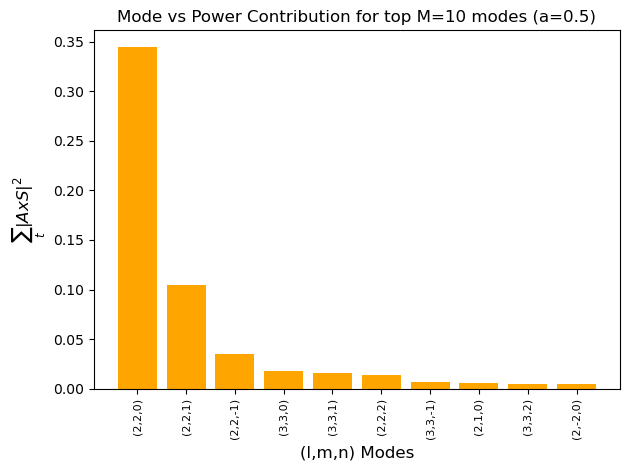

In [18]:
plt.bar(range(len(mp_power)), mp_power, color='orange')
plt.xticks(range(len(mp_modes)), mp_modes, rotation=90, fontsize=8)
plt.xlabel('(l,m,n) Modes', fontsize=12)
plt.ylabel(r'$\sum_{t} |AxS|^2$', fontsize=12)
plt.title('Mode vs Power Contribution for top M={} modes (a={})'.format(M_mode,a), fontsize=12)
plt.yscale('linear')
plt.tight_layout()
plt.show()

In [19]:
# Pick modes based on top M power contributions
top_indices = [mode_labels.index(mode) for mode in mp_modes]
print("Top mode indices:", top_indices)

Top mode indices: [1165, 1166, 1164, 1498, 1499, 1167, 1497, 1054, 1500, 7159]


In [20]:
t_gpu = cp.asarray(t)

In [21]:
for arr_idx, mode_idx in enumerate(top_indices):
    print(arr_idx, mode_idx)

0 1165
1 1166
2 1164
3 1498
4 1499
5 1167
6 1497
7 1054
8 1500
9 7159


In [22]:
waveform_per_mode = cp.empty(M_mode, dtype=cp.complex128)
for arr_idx, mode_idx in enumerate(top_indices):
    print(waveform_per_mode[arr_idx])

(1.20041301922602e-309+1.22214225613056e-309j)
(1.243871493035105e-309+1.26560072993965e-309j)
(1.271924277400727e-309+1.287860465792057e-309j)
(1.3095897026966e-309+1.331318939601144e-309j)
(1.35304817650569e-309+1.37477741341023e-309j)
(1.396506650314775e-309+0.07886171341033885j)
(-0.351140183788066+0j)
(-0.09809629333925872-0.09809629333925872j)
(1.7379364131453588e-17+0.28382655543710694j)
(-0.18065037635431755+0.18065037635431758j)


In [23]:
len(top_indices)

10

In [24]:
%%time

waveform_per_mode = cp.empty((M_mode, N), dtype=cp.complex128)
for arr_idx, mode_idx in enumerate(top_indices):
    l = amp.l_arr[mode_idx]
    m = amp.m_arr[mode_idx]
    n = amp.n_arr[mode_idx]

    if m >= 0:
        teuk_modes_single = teuk_modes[:, [mode_idx]]
        ylms_single = ylms[[mode_idx]]
        m_arr = amp.m_arr[[mode_idx]]
    else:
        pos_m_mask = (amp.l_arr == l) & (amp.m_arr == -m) & (amp.n_arr == n)
        pos_m_idx = cp.where(pos_m_mask)[0][0]
        teuk_modes_single = (-1)**l * cp.conj(teuk_modes[:, [pos_m_idx]])
        ylms_single = ylms[[mode_idx]]
        m_arr = cp.abs(amp.m_arr[[mode_idx]])  # Use cp.abs instead of np.abs

    waveform = interpolate_mode_sum(
        t_gpu, teuk_modes_single, ylms_single,
        traj.integrator_spline_t, traj.integrator_spline_phase_coeff[:, [0, 2]],
        amp.l_arr[[mode_idx]], m_arr, amp.n_arr[[mode_idx]], 
        dt=dt, T=T
    )
    waveform_per_mode[arr_idx] = waveform / factor

cp.cuda.Stream.null.synchronize()

CPU times: user 38.9 ms, sys: 10.9 ms, total: 49.8 ms
Wall time: 79.3 ms


In [25]:
%%time
waveform_per_mode = []
for idx in top_indices:
    l = amp.l_arr[idx]
    m = amp.m_arr[idx]
    n = amp.n_arr[idx]

    if m >= 0:
        teuk_modes_single = teuk_modes[:, [idx]]
        ylms_single = ylms[[idx]]
        m_arr = amp.m_arr[[idx]]
    else:
        pos_m_mask = (amp.l_arr == l) & (amp.m_arr == -m) & (amp.n_arr == n)
        pos_m_idx = cp.where(pos_m_mask)[0][0]
        teuk_modes_single = (-1)**l * cp.conj(teuk_modes[:, [pos_m_idx]])
        ylms_single = ylms[[idx]]
        m_arr = cp.abs(amp.m_arr[[idx]])  # Use cp.abs instead of np.abs

    waveform = interpolate_mode_sum(
        t_gpu, teuk_modes_single, ylms_single,
        traj.integrator_spline_t, traj.integrator_spline_phase_coeff[:, [0, 2]],
        amp.l_arr[[idx]], m_arr, amp.n_arr[[idx]], 
        dt=dt, T=T
    )
    waveform_per_mode.append(waveform / factor)

cp.cuda.Stream.null.synchronize()

CPU times: user 32.6 ms, sys: 9.99 ms, total: 42.6 ms
Wall time: 42.3 ms


In [26]:
len(waveform_per_mode[0])

3155815

# $\rho$

In [27]:
def rhostat(h):
    # optimal SNR 
    # assuming the h is still in time-domain
    
    hf = gwf.freq_wave(h) 
    calc_inner = gwf.inner(hf, hf)
    return gwf.xp.sqrt(calc_inner)  # TODO: Change to self.xp when putting in GWfuncs

In [28]:
rhostat(h_temp)

array(28.6784206)

In [29]:
rho_tot = rhostat(h_temp)

In [30]:
isinstance(rhostat(h_temp), cp.ndarray)

True

# $\rho_m$

In [31]:
def rhostat_modes(hm_arr): 
    rho_modes = gwf.xp.empty(len(hm_arr), dtype=gwf.xp.float64)

    for idx, hm in enumerate(hm_arr):
        rho_modes[idx] = rhostat(hm)
    
    # for hm in hm_arr:
    #     rho_m = rhostat(hm)
    #     rho_modes.append(rho_m)
    
    return gwf.xp.array(rho_modes)

In [32]:
%%time
rho_modes = rhostat_modes(waveform_per_mode)
cp.cuda.Stream.null.synchronize()

CPU times: user 156 ms, sys: 965 μs, total: 157 ms
Wall time: 157 ms


In [33]:
rho_modes

array([19.3845998 , 15.44948069,  2.82934452,  7.48310092,  7.88902653,
        6.62770726,  3.25574535,  0.65460134,  4.26052188,  2.15384353])

# $X$

In [34]:
def Xstat(x, h):
    # x = data, in this case: h_true
    # GPU-compatible version
    
    xf = gwf.freq_wave(x) 
    hf = gwf.freq_wave(h)
    
    calc_inner = gwf.inner(xf, hf)
    calc_SNR = gwf.xp.sqrt(gwf.inner(hf, hf))  
    return calc_inner / calc_SNR

In [35]:
Xstat(h_true, h_temp)

array(-0.00515384)

In [36]:
isinstance(Xstat(h_true, h_temp), cp.ndarray)

True

Also do try the other way (from rho, x..)

# $X_m$

In [37]:
def Xmstat(x, hm_arr, rho_modes):
    """
    Calculate X_m for each mode
    x: data (h_true in your case)
    hm_arr: list of mode waveforms 
    rho_modes: already computed rho values for each mode
    """
    X_modes = gwf.xp.empty(len(hm_arr), dtype=gwf.xp.complex128)
    
    # Get frequency domain of data once
    xf = gwf.freq_wave(x)
    
    for idx, hm in enumerate(hm_arr):
        # Get frequency domain of mode template
        hmf = gwf.freq_wave(hm)
        
        # Calculate inner product <x|hm>
        inner_product = gwf.inner(xf, hmf)
        
        # X_m = <x|hm> / rho_m
        X_modes[idx] = inner_product / rho_modes[idx]
    
    return X_modes

In [38]:
Xmstat(h_true, waveform_per_mode, rho_modes)

array([-9.57988516e-04+0.j, -2.25731924e-05+0.j, -1.11018128e-03+0.j,
       -1.62080162e-02+0.j,  2.33888879e-04+0.j,  2.09501447e-02+0.j,
       -3.76350649e-02+0.j, -2.65447499e-04+0.j, -1.15358770e-03+0.j,
        9.55815118e-04+0.j])

In [39]:
def Xscalar_from_modes(X_modes, rho_modes):
    """
    Calculate scalar X(θ) from mode components
    """
    # Calculate X dot rho
    X_dot_rho = gwf.xp.sum(X_modes * rho_modes)
    
    # Calculate sqrt(sum_m rho_m^2)
    rho_norm = gwf.xp.sqrt(gwf.xp.sum(rho_modes**2))

    X_scalar = X_dot_rho / rho_norm
    
    return X_scalar

In [40]:
# Calculate Xm 
X_modes = Xmstat(h_true, waveform_per_mode, rho_modes)

# Get Xscalar from Xm and rho_m
X_scalar_from_modes = Xscalar_from_modes(X_modes, rho_modes)

# Compare with direct calculation
X_scalar_direct = Xstat(h_true, h_temp)

print("X from modes:", X_scalar_from_modes)
print("X direct:", X_scalar_direct)
print("Difference:", abs(X_scalar_from_modes - X_scalar_direct))

X from modes: (-0.004481564011587729+0j)
X direct: -0.005153842286300996
Difference: 0.000672278274713267


# $\alpha = \rho_m / \rho$

In [41]:
rho_modes / rhostat(h_temp) # TODO: make func

array([0.67592982, 0.53871449, 0.09865761, 0.26093142, 0.27508581,
       0.23110433, 0.11352596, 0.02282557, 0.14856194, 0.07510328])

In [42]:
def alphastat(hm_arr, h):
    """
    Calculate alpha_m = rho_m / rho
    hm_arr: list of mode waveforms
    h_temp: template waveform
    """
    rho_modes = rhostat_modes(hm_arr)
    rho_tot = rhostat(h)  
    
    return rho_modes / rho_tot

In [43]:
alpha = alphastat(waveform_per_mode, h_temp)
alpha

array([0.67592982, 0.53871449, 0.09865761, 0.26093142, 0.27508581,
       0.23110433, 0.11352596, 0.02282557, 0.14856194, 0.07510328])

# $\beta$

In [44]:
def betastat(alpha, h):
    rho_tot = rhostat(h)
    
    num = 2 * gwf.xp.log(alpha*rho_tot) 
    denom = (1-alpha**2) * rho_tot**2 
    return num / denom

In [45]:
betastat(alpha, h_temp)

array([ 0.01327312,  0.00937903,  0.00255399,  0.00525183,  0.00543392,
        0.00485857,  0.00290797, -0.00103094,  0.00360411,  0.00187636])

In [46]:
2*gwf.xp.log(alpha*rho_tot) / ((1-alpha**2) * rho_tot**2)

array([ 0.01327312,  0.00937903,  0.00255399,  0.00525183,  0.00543392,
        0.00485857,  0.00290797, -0.00103094,  0.00360411,  0.00187636])

# $\chi^2$

In [47]:
def chi_sq(X_theta, rho_theta):
    """
    Calculate χ²(θ) = |X(θ) - ρ(θ)|²
    
    X_theta: X statistic (can be complex)
    rho_theta: ρ statistic (typically real)
    """
    diff = X_theta - rho_theta
    return gwf.xp.abs(diff)**2

In [48]:
chi_sq(X_scalar_direct, rho_tot)

array(822.74744269)

In [51]:
chi_sq(X_modes, rho_modes)

array([375.79985091, 238.6871511 ,   8.01147383,  56.23963455,
        62.23304926,  43.64923952,  10.84635453,   0.42885051,
        18.1618778 ,   4.63492551])

# $f$

In [49]:
def fstat(X_theta, beta_theta, chi2_theta):
    exp = -0.5 * beta_theta * chi2_theta
    return X_theta * gwf.xp.exp(exp)

In [52]:
fstat(X_scalar_direct, betastat(alpha, h_temp), chi_sq(X_modes, rho_modes))

array([-0.00042559, -0.00168273, -0.00510138, -0.00444625, -0.0043521 ,
       -0.00463532, -0.0050732 , -0.00515498, -0.00498789, -0.00513148])